<a href="https://colab.research.google.com/github/benzirahmed/SER-6506/blob/main/Speech_FF_Max_CNN_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#To check how much RAM is available: See the last line.
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=ac7cfaabc773e00bc714b3cc227f1e889aed3e476273529dec698c4dad77896d
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.8 GB  | Proc size: 111.6 MB
GPU RAM Free: 15079MB | Used: 0MB | Util   0% | Total 15079MB


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name() # To check that GPU is used.

'/device:GPU:0'

In [ ]:
!kill -9 -1 # To clear RAM

In [ ]:
# Import libraries 
import librosa
import librosa.display
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import pandas as pd
import glob 
import IPython.display as ipd  # To play sound in the notebook
import os
import sys
import warnings

# Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv2D, MaxPool2D, AveragePooling1D, Bidirectional
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

# sklearn
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other
import json
import seaborn as sns
import pickle

# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [ ]:
# Need to mount google drive to access files there
from google.colab import drive # to use docs at google drive, you need to mount your google drive
drive.mount('/gdrive/') # your files are at /gdrive/'My Drive'/


Mounted at /gdrive/


In [ ]:
#COLAB_DRIVE_LOC = "/gdrive/My Drive/Colab Notebooks/"
COLAB_DRIVE_LOC = "/gdrive/My Drive/BenColab/Colab Notebooks/"
from datetime import datetime
def printCurrentTime():
  print("Current Time =", datetime.now().strftime("%H:%M:%S"))

In [ ]:
!ls "/gdrive/My Drive/BenColab/Colab Notebooks"

In [ ]:
# !!!!!!! Go directly to cell that loads the data from .csv file. Skip all the following cells!!!!!!!!!
%ls

sample_data/


In [ ]:
RAV = COLAB_DRIVE_LOC+"dataSets/ravdess/Audio_Speech_Actors_01-24/"

In [ ]:
# RAVDESS: COMMON
dir_list = os.listdir(RAV)
dir_list.sort()

emotion = []
gender = []
path = []
for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        temp = int(part[2])
        #if temp >= 2:
         # temp = temp - 1
        emotion.append(temp)       
        path.append(RAV + i + '/' + f)
        
RAV_df = pd.DataFrame(emotion)

RAV_df.columns = ['labels']

RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
#RAV_df = RAV_df.drop(['gender', 'emotion'], axis=1)
printCurrentTime()
RAV_df.labels.value_counts()

Current Time = 09:33:35


8    192
7    192
6    192
5    192
4    192
3    192
2    192
1     96
Name: labels, dtype: int64

In [ ]:
# Lets pick up the meta-data that we got from our first part of the Kernel
ref = pd.concat([RAV_df], axis = 0)
#ref = pd.read_csv("/content/Data_path.csv")
ref.head()

,labels,path
0,1,/gdrive/My Drive/BenColab/Colab Notebooks/data...
1,1,/gdrive/My Drive/BenColab/Colab Notebooks/data...
2,1,/gdrive/My Drive/BenColab/Colab Notebooks/data...
3,2,/gdrive/My Drive/BenColab/Colab Notebooks/data...
4,2,/gdrive/My Drive/BenColab/Colab Notebooks/data...


In [ ]:
# This function stacks Different Features
def extract_feature(path, sr, **kwargs):
    """
    Extract feature from audio file `file_name`
        Features supported:
            - MFCC (mfcc)
            - Chroma (chroma)
            - MEL Spectrogram Frequency (mel)
            - Contrast (contrast)
            - Tonnetz (tonnetz)
        e.g:
        `features = extract_feature(path, mel=True, mfcc=True)`
    """
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=sr,offset=0.5)  
    #female_mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)   
   
    if chroma or contrast:
        stft = np.abs(librosa.stft(X))
    result = np.array([])
    if mfcc:
        mfccs = np.max(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40), axis=0)
        #print(mfccs.shape)
        #result = np.column_stack((result, mfccs))
        result = mfccs
    if chroma:
        chroma = np.max(librosa.feature.chroma_stft(S=stft, sr=sample_rate),axis=0)
        #print(chroma.shape)
        result = np.column_stack((result, chroma))
    if mel:
        mel = np.max(librosa.feature.melspectrogram(X, sr=sample_rate),axis=0)
        # Convert to log scale (dB). We'll use the peak power (max) as reference.
        log_mel = librosa.power_to_db(mel, ref=np.max) 
        #print(mel.shape)
        result = np.column_stack((result, log_mel))
    if contrast:
        contrast = np.max(librosa.feature.spectral_contrast(S=stft, sr=sample_rate),axis=0)
        #print(contrast.shape)
        result = np.column_stack((result, contrast))
    if tonnetz:
        tonnetz = np.max(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate),axis=0)
        #print(tonnetz.shape)
        result = np.column_stack((result, tonnetz))
    return result

In [ ]:
# Run only to check the size of all the features
# Note this takes a couple of minutes (~10 mins) as we're iterating over 4 datasets 

df = pd.DataFrame(columns=['feature'])

# Loop: feature extraction over the entire dataset
sizes = []
sr = 22050
for index, path in enumerate(ref.path):
    features = extract_feature(path, sr, mfcc=True, chroma=True, mel=True, contrast=True, tonnetz=True) 
        
    # Adding the size to the list
    sizes.append(features.shape)    

# Checking if all sizes are the same
print(f'The sizes of all the mel spectrograms in our data set are equal: {len(set(sizes)) == 1}')

# Checking the max size
print(f'The maximum size is: {max(sizes)}')

The sizes of all the mel spectrograms in our data set are equal: False
The maximum size is: (108, 5)


In [ ]:
# Reads data, do mel spectrum: COMMON
# Note this takes a couple of minutes (~10 mins) as we're iterating over 4 datasets 

df = pd.DataFrame(columns=['feature'])

# Loop: feature extraction over the entire dataset
specs = []
counter=0
sr = 22050
for index, path in enumerate(ref.path):
    features = extract_feature(path, sr, mfcc=True, chroma=True, mel=True, contrast=True, tonnetz=True) 
        
    # Adjusting the size to be 108 x 5
    if features.shape[0] != 108:
        features.resize(108,5, refcheck=False)

    # Adding the 2-D mel spectrogram to the list
    specs.append(features)  
    
    df.loc[counter] = [features]
    counter=counter+1    

# Converting the list or arrays to an array
X = np.array(specs)  
#newarray = np.dstack(specs)   

In [ ]:
# Preprocess: : COMMON
# replace NA with 0
df = df.fillna(0)

#features = df.drop(['path','labels','source'],axis=1)
#n = features.shape[0]
labels = ref.labels.to_list()

# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(X
                                                    , labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )
# Lets do data normalization 
max_data = np.max(X_train)
min_data = np.min(X_train)

X_train = (X_train-min_data)/(max_data-min_data+1e-6)
X_train =  X_train-0.5

max_data = np.max(X_test)
min_data = np.min(X_test)
X_test = (X_test-min_data)/(max_data-min_data+1e-6)
X_test =  X_test-0.5

In [ ]:
# Lets do few preparation steps to get it into the correct format for Keras : COMMON

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# one hot encode the target(Check whether emotions are already numeric): 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

# Pickel the lb object for future use 
#filename = COLAB_DRIVE_LOC+'dataSets/ravdess/labels'
#outfile = open(filename,'wb')
#pickle.dump(lb,outfile)
#outfile.close()

# We need to convert to 3D as we use CNN
X_train_cnn = np.expand_dims(X_train, axis=3)
X_test_cnn = np.expand_dims(X_test, axis=3)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_train_cnn.shape)

(1080, 108, 5)
(1080, 8)
(1080, 108, 5, 1)


In [ ]:
from keras.layers import Layer
import keras.backend as K

class Attention(Layer):
    def __init__(self,**kwargs):
        super(Attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1],1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1],1), initializer="zeros")        
        super(Attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh( K.dot(x,self.W)+self.b ), axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(Attention,self).get_config()

In [ ]:
def ReshapeLayer(x):    
    shape = x.shape    
    # 1st possibility: H,W*channel
    reshape = Reshape((shape[1],shape[2]*shape[3]))(x)
    
    # 2nd possibility: W,H*channel
    # transpose = Permute((2,1,3))(x)
    # reshape = Reshape((shape[1],shape[2]*shape[3]))(transpose)
    
    return reshape

In [ ]:
# CNN Model Base
from keras.layers import Bidirectional, ConvLSTM2D, Reshape, Lambda 
lstm_node = 10
model = Sequential()
model.add(Conv2D(input_shape=(108,5,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Dropout(.2))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Dropout(.2))

model.add(Flatten())
model.add(Dense(units=256,activation="relu"))
model.add(Dense(units=8, activation="softmax"))

In [ ]:
# CNN Model - draft
from keras.layers import Bidirectional, ConvLSTM2D, Reshape, Lambda 
lstm_node = 10
model = Sequential()
model.add(Conv2D(input_shape=(108,5,1),filters=128,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
#model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Dropout(.2))
#model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))

model.add(Flatten())
model.add(Dense(units=256,activation="relu"))
model.add(Dense(units=8, activation="softmax"))

In [ ]:
# Optimizer
# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
opt = keras.optimizers.Adam(lr=0.0001)
#opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

#COLAB_DRIVE_LOC = "/gdrive/My Drive/Colab Notebooks/"
SAVED_MODELS = COLAB_DRIVE_LOC + "dataSets/ravdess/"

from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint(SAVED_MODELS+"vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early_stopping = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

#model_history = model.fit_generator(steps_per_epoch=100, generator=traindata, validation_data= testdata, validation_steps=10, epochs=100, callbacks=[checkpoint, early])
#model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping])
model_history = model.fit(X_train_cnn, y_train, batch_size=16, epochs=100, validation_data=(X_test_cnn, y_test), callbacks=[checkpoint, early_stopping])

Epoch 1/100
68/68 [==============================] - 1s 18ms/step - loss: 2.0663 - accuracy: 0.1852 - val_loss: 2.0248 - val_accuracy: 0.2250
Epoch 2/100
68/68 [==============================] - 1s 14ms/step - loss: 1.9616 - accuracy: 0.2269 - val_loss: 1.9011 - val_accuracy: 0.2667
Epoch 3/100
68/68 [==============================] - 1s 14ms/step - loss: 1.8636 - accuracy: 0.2759 - val_loss: 1.8091 - val_accuracy: 0.3500
Epoch 4/100
68/68 [==============================] - 1s 14ms/step - loss: 1.8012 - accuracy: 0.2870 - val_loss: 1.8099 - val_accuracy: 0.3306
Epoch 5/100
68/68 [==============================] - 1s 14ms/step - loss: 1.7648 - accuracy: 0.3194 - val_loss: 1.7620 - val_accuracy: 0.3139
Epoch 6/100
68/68 [==============================] - 1s 14ms/step - loss: 1.7339 - accuracy: 0.3204 - val_loss: 1.7592 - val_accuracy: 0.3250
Epoch 7/100
68/68 [==============================] - 1s 14ms/step - loss: 1.7216 - accuracy: 0.3315 - val_loss: 1.7311 - val_accuracy: 0.3611
Epoch 

In [ ]:
# the confusion matrix heat map plot
def print_confusion_matrix(confusion_matrix, class_names, file_name, title, figsize = (10,7), fontsize=14):
    
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title = title
    plt.savefig('Metrics-'+file_name+'-ConfustionMetrix')
    return plt

accuracy: 40.83%
23/23 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

       angry       0.43      0.42      0.43        52
        calm       0.49      0.67      0.57        45
     disgust       0.41      0.33      0.37        45
        fear       0.48      0.55      0.51        40
       happy       0.28      0.29      0.29        48
     neutral       0.39      0.35      0.37        26
         sad       0.33      0.27      0.29        49
    surprise       0.42      0.40      0.41        55

    accuracy                           0.41       360
   macro avg       0.40      0.41      0.40       360
weighted avg       0.40      0.41      0.40       360



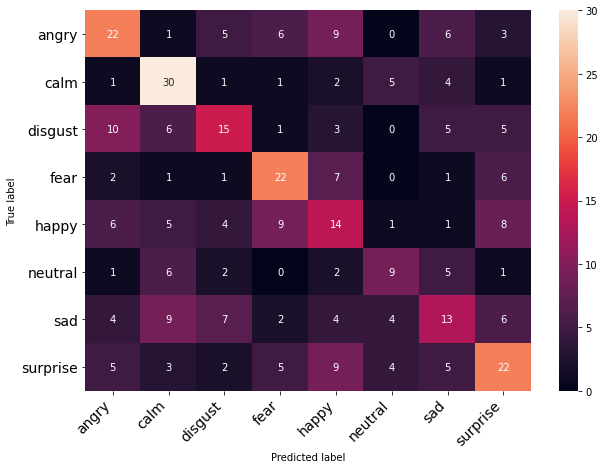

In [ ]:
# Test / Evaluation
score = model.evaluate(X_test_cnn, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

preds = model.predict(X_test_cnn, batch_size=16, verbose=1)
preds = preds.argmax(axis=1)

# Predicted Labels 
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual Labels
actual = y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(preds)
#print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues)*100)

# Write out the predictions to disk
#finaldf = finaldf.replace({1:'neutral', 2:'happy', 3:'sad', 4:'angry', 5:'fear', 6:'disgust', 7:'surprise'})
finaldf = finaldf.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})

finaldf.to_csv(SAVED_MODELS+'Predictions.csv', index=False)
finaldf.groupby('predictedvalues').count()
classes_names = finaldf.actualvalues.unique()
classes_names.sort()

# Classification report 
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes_names))
report = classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes_names, output_dict=True)
#print(report)
# To store to files
classsReportDf = pd.DataFrame(report).transpose()
classsReportDf.to_csv('Metrics-CNN-Max-Attention.csv') #(Saved to .csv file)

# Confusion matrix 
c_matrix = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
confustionPlt = print_confusion_matrix(c_matrix, class_names = classes_names, file_name='CNN', title='CNN Confusion Metrics')#This function implemented above
confustionPlt.show() # Will also save to .png file

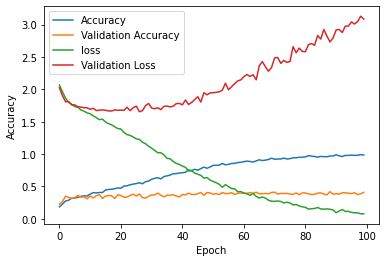

In [ ]:
def plotAccLossCurves():
  # Curve plot of Accuracy, Validation accuracy, loss, and Validation loss.
  plt.plot(model_history.history["accuracy"])
  plt.plot(model_history.history['val_accuracy'])
  plt.plot(model_history.history['loss'])
  plt.plot(model_history.history['val_loss'])
 # plt.title("model accuracy")
  plt.ylabel("Accuracy")
  plt.xlabel("Epoch")
  plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
  plt.savefig('Metrics-CNN-Graph')
  return plt

plt = plotAccLossCurves() # saved to .png file below

In [ ]:
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes_names))

              precision    recall  f1-score   support

       angry       0.65      0.62      0.63        52
        calm       0.43      0.67      0.52        45
     disgust       0.51      0.64      0.57        45
        fear       0.58      0.38      0.45        40
       happy       0.35      0.42      0.38        48
     neutral       0.20      0.08      0.11        26
         sad       0.38      0.16      0.23        49
    surprise       0.47      0.60      0.53        55

    accuracy                           0.47       360
   macro avg       0.45      0.44      0.43       360
weighted avg       0.46      0.47      0.45       360



In [ ]:
# To store to files (Doesn't work now)
'''classsReportDf = pd.DataFrame(report).transpose()
classsReportDf.to_csv('Metrics-CNN-LSTM-Attention.csv')

confustionPlt.savefig('Metrics-CNN-LSTM-ConfustionMetrix-Attention')

#plt.savefig('Metrics-CNN-LSTM-Graph-Attention') # It doesn't work'''

<Figure size 432x288 with 0 Axes>